In [0]:
# Google colab dependencies
import os
!pip install pyspark > /dev/null
!pip install -U -q PyDrive
!pip install -U nltk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyvis > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.4.5)


In [0]:
# General Dependencies
import re
import os
import pickle
import scipy.stats
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
from operator import itemgetter
from sklearn import metrics
from matplotlib.ticker import FormatStrFormatter
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from itertools import combinations
from pyspark.sql.functions import split, explode, monotonically_increasing_id,concat
from scipy.sparse import csr_matrix
import networkx as nx
from pyvis.network import Network
from typing import Iterable
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet as wn


In [0]:
import pyspark
import pyspark.sql
from pyspark.sql import *

from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, FloatType

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','4g'), # your
                                   ('spark.driver.maxResultSize', '2G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Description
The goal of this project is to create a graph to observe relations between items. To do so, we will group transaction data by shopping cart and we will create an adjacency matrix containing the number of times a pair appears in all shopping carts. We will then create a graph where nodes are items and edges are weighted by the number of times they appear together. 

# Load Data


In [0]:
path = '/content/drive/My Drive/TermProject/data/dunnhumby - The Complete Journey CSV'
transaction_df = spark.read.csv(os.path.join(path,"transaction_data.csv"),header="true")
product_df = spark.read.csv(os.path.join(path,"product.csv"),header="true")
demographic_df = spark.read.csv(os.path.join(path,"hh_demographic.csv"),header="true")

In [0]:
transaction_df.printSchema()
transaction_df = transaction_df.withColumn("SALES_VALUE", transaction_df["SALES_VALUE"].cast(DoubleType()))


root
 |-- household_key: string (nullable = true)
 |-- BASKET_ID: string (nullable = true)
 |-- DAY: string (nullable = true)
 |-- PRODUCT_ID: string (nullable = true)
 |-- QUANTITY: string (nullable = true)
 |-- SALES_VALUE: string (nullable = true)
 |-- STORE_ID: string (nullable = true)
 |-- RETAIL_DISC: string (nullable = true)
 |-- TRANS_TIME: string (nullable = true)
 |-- WEEK_NO: string (nullable = true)
 |-- COUPON_DISC: string (nullable = true)
 |-- COUPON_MATCH_DISC: string (nullable = true)



In [0]:
product_df.printSchema()

root
 |-- PRODUCT_ID: string (nullable = true)
 |-- MANUFACTURER: string (nullable = true)
 |-- DEPARTMENT: string (nullable = true)
 |-- BRAND: string (nullable = true)
 |-- COMMODITY_DESC: string (nullable = true)
 |-- SUB_COMMODITY_DESC: string (nullable = true)
 |-- CURR_SIZE_OF_PRODUCT: string (nullable = true)



Parse subcommodity description

In [ ]:
product_df.show()

Join transaction data with product data

In [0]:
trans_prod_df = transaction_df\
.select('PRODUCT_ID','household_key','BASKET_ID','QUANTITY','SALES_VALUE')\
.join(product_df.select('PRODUCT_ID','COMMODITY_DESC','SUB_COMMODITY_DESC','CURR_SIZE_OF_PRODUCT','DEPARTMENT'),on='PRODUCT_ID')
trans_prod_df.show(3)

+----------+-------------+-----------+--------+-----------+--------------------+--------------------+--------------------+----------+
|PRODUCT_ID|household_key|  BASKET_ID|QUANTITY|SALES_VALUE|      COMMODITY_DESC|  SUB_COMMODITY_DESC|CURR_SIZE_OF_PRODUCT|DEPARTMENT|
+----------+-------------+-----------+--------+-----------+--------------------+--------------------+--------------------+----------+
|   1004906|         2375|26984851472|       1|       1.39|            POTATOES|POTATOES RUSSET (...|                5 LB|   PRODUCE|
|   1033142|         2375|26984851472|       1|       0.82|              ONIONS|ONIONS SWEET (BUL...|               40 LB|   PRODUCE|
|   1036325|         2375|26984851472|       1|       0.99|VEGETABLES - ALL ...|              CELERY|                    |   PRODUCE|
+----------+-------------+-----------+--------+-----------+--------------------+--------------------+--------------------+----------+
only showing top 3 rows




# Make Adjacency Matrix
The adjacency matrix of the graph will contain the number of times a given pair of items appeared together in a shopping cart added up over all shopping carts. 

## Get set of bought items per shopping cart
We will groupby Basket ID and collect a set of bought items. It is necessary to collect set because we don't want repeated items per basket.

In [0]:
basket_items = trans_prod_df.groupBy('BASKET_ID')\
               .agg(collect_set('SUB_COMMODITY_DESC')\
               .alias('item_list'))
basket_items.show(3)

+-----------+--------------------+
|  BASKET_ID|           item_list|
+-----------+--------------------+
|27031281714|[SOFT DRINK POWDE...|
|27191583855|[TRAY PACK/CHOC C...|
|27232395780|[MICROWAVE, SMOKI...|
+-----------+--------------------+
only showing top 3 rows



## Explode list
Get a long basket id vs. single item dataframe

In [0]:
b_items_exploded = basket_items\
                    .select("BASKET_ID", explode("item_list").alias('item'))

In [0]:
b_items_exploded.toPandas().head(3)

,BASKET_ID,item
0,27031281714,SOFT DRINK POWDER POUCHES
1,27031281714,SUGAR
2,27031281714,TOILET TISSUE


# Make Co-ocurrence Matrix
Now that we have an exploded df, we can use the cross-tab function comparing it with itself to get a matrix showing the co-ocurrences of items per basket id. We join the item column with itself and then we cross-tab. To ensure we only compare a single basket at a time, we use the basket id as a key for the join before doing the cross tab. 

In [0]:
co_ocurrence_df = b_items_exploded.withColumnRenamed("item", "item_")\
                  .join(b_items_exploded, "BASKET_ID")\
                  .stat.crosstab("item_", "item")


In [ ]:
co_ocurrence_df.sort(col(' ').desc()).show()

We see that the matrix still contains the main diagonal (which we don't want as edges), and it also contains a blank commodity which corresponds to items being bought alone. We will now modify this matrix to account for this.

## Matrix Modification


Go back to pandas 

In [0]:
co_ocurrence_pd = co_ocurrence_df.toPandas()

Remove empty category

In [0]:
co_ocurrence_pd.drop(' ',axis=1,inplace=True)

Melt sparse matrix into a long column matrix. We do this because this way we can easily remove the diagonal, and we can also filter the upper diagonal part since its a symmetric matrix. 

In [0]:
co_ocurrence_pd_long = co_ocurrence_pd\
.melt(co_ocurrence_pd.columns[0],co_ocurrence_pd.columns[1:])\
.rename(columns={"item__item": "item1", "variable": "item2","value":"freq"})\
.sort_values('freq',ascending=False)

Remove main diagonal


In [0]:
co_ocurrence_pd_long = co_ocurrence_pd_long[co_ocurrence_pd_long['item1']!=co_ocurrence_pd_long['item2']]

## Distribution of co-ocurrences
We want to see how the connections are distributed accross the nodes

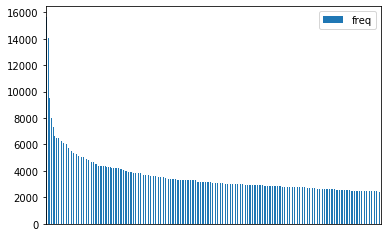

In [0]:
ax = co_ocurrence_pd_long[co_ocurrence_pd_long.freq!=0].head(200).plot.bar()
ax.get_xaxis().set_visible(False)


In [0]:
co_ocurrence_pd_long[co_ocurrence_pd_long.freq!=0].describe().round(2)

,freq
count,997654.00
mean,24.51
std,101.81
min,1.00
25%,1.00
50%,4.00
75%,13.00
max,15662.00


We see that some 75% of the pairs are present less than 13 times! However, the most ocurring pair appears 15662 times. This means that the graph will probably be fully connected and hard to visualize if we want to find meaningful relations or groups between items.




## Normalize Frequencies by the Total Occurrence of the item
We can then apply the following transformation:


t_f = f_i/sum(f_i)


This will allow us to decrease the weight of those items that always appear, and highlight relations between not-as-common items. 

After applying this transformation, the co-ocurrence matrix will no longer be symmetric because the co-ocurrences will be normalized by item-frequency. We will then choose the smallest score from the two values for each pair so that we prioritize the values obtained from the columns of the highest frequencies, as they will be more representative of their true relation. 


Go back to matrix form.

In [0]:
co_ocurrence_pd = co_ocurrence_pd_long\
.pivot(index='item1', columns='item2', values='freq')\
.drop(' ',axis=0).fillna(0)

We can now normalize each entry by the sum of each column

In [0]:
#normalize by item ocurrence
co_ocurrence_pd = co_ocurrence_pd.div(co_ocurrence_pd.sum(axis=0),axis=1)


#normalize and weight by log of occurence
#co_ocurrence_pd = co_ocurrence_pd\
#                  .div(co_ocurrence_pd.sum(axis=0), axis=1)\
#                  .mul(np.log(co_ocurrence_pd.sum(axis=0)+1)) # normalize by column

In [0]:
co_ocurrence_pd.reset_index(inplace=True)

After normalization, we can go back to long format

In [0]:
co_ocurrence_pd_long = co_ocurrence_pd\
.melt(co_ocurrence_pd.columns[0],co_ocurrence_pd.columns[1:])\
.rename(columns={"variable": "item2","value":"freq"})\
.sort_values('freq',ascending=False)

We can see that all the rows contain highly related products! However, the top pairs are also being confounded with those pairs that only appeared once in all the shopping carts. 

## Take Smallest Normalized Frequency
For each pair we have 2 normalized values: one corresponding to the frequency normalized by the first item, and the other one corresponding to the frequency normalized by the second item. In the graph we only need one edge between the two items, so we must select one of these values. We will select the smallest one because it is calculated from the item that is more recurrent. Therefore, the smallest value will more effectively represent the true link between these two items.

To implement this we will create a new column with the appended items. We will sort them, and remove duplicates, choosing the second value since the list is already sorted by frequency. 

create new column containing list of sorted items

In [0]:
co_ocurrence_pd_long['items'] = (np.sort(co_ocurrence_pd_long.values[:,[0,1]]).tolist())

Turn into string to be able to compare against other rows

In [0]:
co_ocurrence_pd_long['items'] = co_ocurrence_pd_long['items'].apply(lambda x: ",".join(x))

Remove duplicates while keeping last item

In [0]:
co_ocurrence_pd_long = co_ocurrence_pd_long.drop_duplicates('items',keep='last')

Remove 0s that will not represent any edges

In [0]:
co_ocurrence_pd_long = co_ocurrence_pd_long[(co_ocurrence_pd_long.freq != 0)]

We see that the items are even more related now. We can now prepare the graph

## Prepare Graph
We can assign edges based on the co-ocurrence value. This will allow us to control the degree of connectedness of the graph.

In [0]:
co_ocurrence_pd_long.describe()

,freq
count,282459.000000
mean,0.000522
std,0.003440
min,0.000002
25%,0.000094
50%,0.000237
75%,0.000569
max,1.000000


We see that most of the values are under 5e-3. This might be a good threshold for our final graph since we want to highlight items that are related. This threshold will allow us to control how connected our graph will be.

In [0]:
graph_info = co_ocurrence_pd_long[co_ocurrence_pd_long.freq>5e-3]

In [0]:
graph_info.describe()

,freq
count,1776.000000
mean,0.009525
std,0.041676
min,0.005000
25%,0.005525
50%,0.006297
75%,0.007954
max,1.000000


Parse nodes names to have cleaner display

In [0]:
def parse_words(sub_c): 
    "Get rid of separators"
    sub_c = sub_c.upper()
    sub_c = list(filter(None,re.split("[;&@\:,\*\.\(\)\{\}\\-%\"\'0-9\_]",sub_c)))
    sub_c = " ".join(sub_c).strip()
    sub_c = sub_c.split()
    sub_c = " ".join(sub_c)
    return sub_c 

In [0]:
graph_info['item1'] = graph_info['item1'].apply(lambda x: parse_words(x))
graph_info['item2'] = graph_info['item2'].apply(parse_words)
graph_info.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,item1,item2,freq,items
2885276,SNACK CRACKERS,LOTTO/GAMBLING MAGAZINE,1.000000,"LOTTO/GAMBLING-MAGAZINE,SNACK CRACKERS"
4081988,PREPARED BEANS BAKED W/PORK,PREMIUM ORCHIDS POTTED,1.000000,"PREMIUM ORCHIDS POTTED,PREPARED BEANS - BAKED ..."
2120047,OUTGOING/INCOMING FTD,FTD SERVICE CHARGES,1.000000,"FTD SERVICE CHARGES,OUTGOING/INCOMING FTD"
2905196,CRV DEPOSIT T/NF,MAGAZINE SUBSCRIPTIONS,0.250000,"CRV DEPOSIT T/NF,MAGAZINE SUBSCRIPTIONS"
1290078,CHUCK/SHLDR ROAST,CORPORATE DELETES DO NOT USE,0.142857,"CHUCK/SHLDR - ROAST,CORPORATE DELETES (DO NOT USE"


### Initialize Graph

In [0]:
G = nx.Graph()

## Nodes 
We want to label the nodes with their total frequency of occurrence

In [0]:
nodes_df = pd.concat([graph_info.item1,graph_info.item2],axis=0).unique()

### Store Total Frequency of Items
Group by item, count total basket ids. 

In [0]:
item_freq_df = trans_prod_df.groupby('SUB_COMMODITY_DESC')\
.agg(countDistinct("BASKET_ID")\
     .alias('count')).sort(col("count")\
                           .desc()).toPandas()

In [0]:
item_freq_df['SUB_COMMODITY_DESC']= item_freq_df.SUB_COMMODITY_DESC.apply(parse_words)

Design label as "count:< freq of item >"
We need to merge the nodes dataframe with frequency database 

In [ ]:
item_freq_df['title'] = item_freq_df['count'].apply(lambda x: 'count: '+str(x))
titles = nodes_df.merge(item_freq_df,how='left').title.tolist()
nodes_df_complete = nodes_df.merge(item_freq_df,how='left').head()
nodes[nodes_df_complete.Sisna()]

In [0]:
print("We have",np.size(nodes),"nodes in total.")

We have 753 nodes in total.


In [0]:
nodes = pd.concat([graph_info.item1,graph_info.item2],axis=0).unique().tolist()
edges = [tuple(x) for x in graph_info.values[:,:3]]

Add nodes to graph

In [0]:
G.add_nodes_from(nodes,labelHighlightBold=True)

In [0]:
G.add_weighted_edges_from(edges)

## Visualization



In [ ]:
net = Network(height="500px", width="800px")
net.barnes_hut(spring_strength=0.015)
net.add_nodes(nodes,title=titles)
net.add_edges(edges)
#net.show_buttons(filter_=['physics'])
net.show('graph_commodities.html')

## Degree Distribution
We will now observe how connected the nodes are.

In [0]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    #ax.set_xticks([d+0.05 for d in deg])
    #ax.set_xticklabels(deg)
    #ax.set_xscale('log')

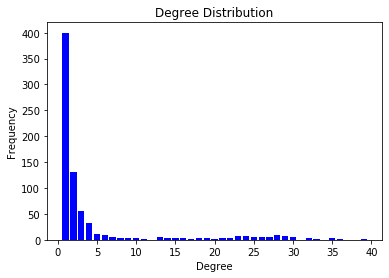

In [0]:
plot_degree_distribution(G)

We see that most nodes have a low degree but there are some with a high degree of connectivity with up to 60 edges

## Connected Components

In [0]:
print(nx.is_connected(G))
comp = list(nx.connected_components(G))
print('The graph contains', len(comp), 'connected components')
lengths = [len(g) for g in (comp)]
largest_comp = np.argmax(lengths)
percentage_lcc = len(comp[largest_comp])/G.number_of_nodes() * 100
print('The largest component has', len(comp[largest_comp]), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes')

False
The graph contains 160 connected components
The largest component has 269 nodes accounting for 35.72 % of the nodes


## Shortest Path of largest Group


In [0]:
bigGroup = G.subgraph(comp[largest_comp])
print("The diameter of the largest connected component is", nx.diameter(bigGroup))
print("The avg shortest path length of the largest connected component is %.2f" % nx.average_shortest_path_length(bigGroup))

The diameter of the largest connected component is 12
The avg shortest path length of the largest connected component is 3.74


## Item Importance 
We will look at the item importance with the degree centrality and with the betweenness centrality

### Degree Centrality
We will compute the degree centrality rather than the Katz centrality due to computational abilities

In [0]:
degrees = dict(bigGroup.degree(bigGroup.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 10 most popular commodities are.. 
for commodity, degree in sorted_degree[:10]:
    print(commodity, 'is connected to', degree, 'other commodities')

PASTA CANNED is connected to 39 other commodities
POTATO CHIPS is connected to 36 other commodities
SUGAR is connected to 35 other commodities
MAINSTREAM WHITE BREAD is connected to 35 other commodities
KIDS CEREAL is connected to 35 other commodities
CORN is connected to 33 other commodities
CHEESE CRACKERS CHEEZ ITS/GOL is connected to 32 other commodities
TUNA is connected to 32 other commodities
ENHANCED is connected to 32 other commodities
SNACKS/APPETIZERS is connected to 32 other commodities


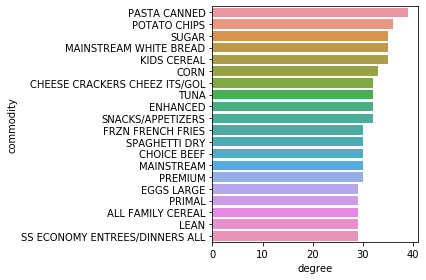

In [0]:
degree_df = pd.DataFrame(sorted_degree,columns=['commodity','degree']).head(20)
ax = sns.barplot(x="degree", y="commodity", data=degree_df)
plt.tight_layout(h_pad=2)
plt.savefig('degree_distribution.png')

It is interesting to see that the top items are not necessarily the most bought items when analysing the sales value of all transactions. Here we see the items that most-co-ocurrent in the shopping carts. 

We see that these items are not very healthy per se. 

### Betweenness Centrality
We can now look at the items where the highest amount of shortest paths pass by. 

In [0]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(bigGroup)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(bigGroup, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for commodity, bw in sorted_betweenness[:10]:
    print(commodity, 'has betweeness: %.3f' %bw)

PAPER TOWELS & HOLDERS has betweeness: 0.122
PAPER NAPKINS has betweeness: 0.072
FOAM PLATES has betweeness: 0.066
CANDY BARS (SINGLES)(INCLUDING has betweeness: 0.060
SS ECONOMY ENTREES/DINNERS ALL has betweeness: 0.058
CANDY BARS (MULTI PACK) has betweeness: 0.051
MAINSTREAM WHITE BREAD has betweeness: 0.047
FRZN SS PREMIUM ENTREES/DNRS/N has betweeness: 0.046
TOILET TISSUE has betweeness: 0.045
SUGAR has betweeness: 0.043


These items on the other hand seem to be neutral items connecting perhaps food with other non-food items. In fact, what is probably the case is that these items are in a single branch of the graph that all shortest paths must pass by. Therefore, this measure is not very relevant. 

## See neighborhoods
We will see whether neighboring items are indeed related

In [0]:
nodes_df = pd.DataFrame(nodes,columns=['sub_commodity_desc'])

In [0]:
def get_neighborhood(item):
  items_in_graph = nodes_df[nodes_df.sub_commodity_desc.str.contains(item.upper())].values.tolist()
  items_in_graph = [item for sublist in items_in_graph for item in sublist]
  for it in items_in_graph:
    print('Neighbors of',it,':\n',net.neighbors(it))

In [0]:
print(",".join(list(net.neighbors('BAR SOAP'))))

HAIR CONDITIONERS AND RINSES,SOLID/STK DEODORANTS,TOILET TISSUE,TOOTHPASTE


In [0]:
get_neighborhood('dip')

Neighbors of REFRIG DIPS :
 {'POTATO CHIPS', 'CORN CHIPS'}
Neighbors of DIPS (NON-REFRIGERATED) :
 {'CORN CHIPS'}
Neighbors of SAL: SALSA/DIPS BULK :
 {'CARBONATED WATER - FLVRD UNSWE'}
Neighbors of DIPS :
 {'CAULIFLOWER WHOLE'}


In [0]:
get_neighborhood('MARSHMALLOW')

Neighbors of MARSHMALLOWS :
 {'CANDY BARS (MULTI PACK)', 'GRAHAM CRACKERS'}
Neighbors of MARSHMALLOW CREME :
 {'COOKING CHOCOLATE (EX SMI-SWT)'}


In [0]:
get_neighborhood('pizza')

Neighbors of PIZZA/ECONOMY :
 {'FRZN FRENCH FRIES', 'LEAN', 'SS ECONOMY ENTREES/DINNERS ALL'}
Neighbors of PIZZA SAUCE :
 {'PEPPERONI/SALAMI', 'PIZZA MIX DRY', 'REFRIG PIZZA&INGRED  N/MEAT DE'}
Neighbors of FROZEN PIZZA :
 {'BARS - GRANOLA/SNACK', 'FROZEN BREAKFAST', 'FROZEN VEGETABLES', 'BREAKFAST BARS/TARTS/SCONES', 'FROZEN CONVENIENCE/POCKETS', 'BOXED PREPARED/ENTREE/DRY PREP'}
Neighbors of PIZZA/PREMIUM :
 {'FRZN MULTI SERVE ENTREES ALL', 'SANDWICHES&HANDHELDS', 'REFRIGERATED SPECILATY ROLLS', 'PREMIUM BREAD', 'WAFFLES/PANCAKES/FRENCH TOAST', 'FRZN SS PREMIUM ENTREES/DNRS/T', 'GRANOLA BARS'}
Neighbors of PIZZA/TRADITIONAL :
 {'LEAN', 'MACARONI & CHEESE DNRS', 'TORTILLA/NACHO CHIPS', 'SNACKS/APPETIZERS', 'ASEPTIC PACK JUICE AND DRINKS', 'MAINSTREAM WHITE BREAD'}
Neighbors of QSR FD: COLD PIZZA :
 {'HAND/BODY/FACIAL (MEDICATED)'}
Neighbors of REFRIG PIZZA&INGRED  N/MEAT DE :
 {'PIZZA SAUCE'}
Neighbors of PIZZA MIX DRY :
 {'PIZZA SAUCE'}


In [0]:
get_neighborhood('candy')

Neighbors of CANDY BAGS-NON CHOCOLATE :
 {'CANDY BAGS-CHOCOCLATE'}
Neighbors of SEASONAL CANDY BAGS-CHOCOLATE :
 {'CANDY BAGS-CHOCOCLATE W/FLOUR', 'CANDY BAGS-CHOCOCLATE'}
Neighbors of CANDY BARS (SINGLES)(INCLUDING :
 {'PASTA: CANNED', 'EGGS - X-LARGE', 'SFT DRNK MLT-PK BTL CARB (EXCP', 'REFRIGERATED BISCUITS REGULAR', 'LIQUID LAUNDRY DETERGENTS', 'NON-CRBNTD DRNKING/MNERAL WATE', 'POTATOES RUSSET (BULK&BAG)', 'FLUID MILK WHITE ONLY', 'CANDY BARS (MULTI PACK)', 'NATURAL CHEESE EXACT WT CHUNKS', 'SNACKS/APPETIZERS', 'SS ECONOMY ENTREES/DINNERS ALL', 'MAINSTREAM WHITE BREAD', 'MARGARINE: TUBS AND BOWLS'}
Neighbors of CANDY BARS (MULTI PACK) :
 {'MARSHMALLOWS', 'SFT DRNK SNGL SRV BTL CARB (EX', 'CANDY BARS (SINGLES)(INCLUDING', 'CANDY BAGS-CHOCOCLATE'}
Neighbors of MISCELLANEOUS CANDY (INCLUDING :
 {'CANDY BAGS-CHOCOCLATE'}
Neighbors of MINTS CANDY & BREATH (NOT LIF :
 {'CHEWING GUM'}
Neighbors of CANDY BAGS-CHOCOCLATE W/FLOUR :
 {'SEASONAL CANDY BAGS-CHOCOLATE'}
Neighbors of CANDY/CHOCO

In [0]:
get_neighborhood('vegetable')

Neighbors of ORIENTAL VEGETABLES :
 {'ORIENTAL OTHER SAUCES MARINAD', 'ORIENTAL NOODLES RICE'}
Neighbors of FRZN BAGGED VEGETABLES- VALUE :
 {'FRZN BOXED VEGETABLES- VALUE A'}
Neighbors of FRZN BAGGED VEGETABLES - PLAIN :
 {'PASTA: CANNED', 'IWS SINGLE CHEESE', 'CELERY', 'FRZN MULTI SERVE ENTREES ALL', 'FRZN FRENCH FRIES', 'SNACKS/APPETIZERS', 'MAINSTREAM WHEAT/MULTIGRAIN BR', 'MAINSTREAM WHITE BREAD', 'MAINSTREAM', 'LIQUID LAUNDRY DETERGENTS', 'NATURAL CHEESE EXACT WT CHUNKS', 'BROTH', 'TUNA', 'SEMI-SOLID SALAD DRESSING MAY', 'SAUCE MIXES GRAVY MIXES DRY', 'MARGARINE: TUBS AND BOWLS', 'MACARONI & CHEESE DNRS', 'SOUR CREAMS', 'MARGARINE  STICK', 'ADULT CEREAL', 'MEAT: TURKEY BULK', 'COTTAGE CHEESE', 'RTS SOUP: CHUNKY/HOMESTYLE ET', 'CORN', 'KIDS CEREAL', 'SOUP CRACKERS (SALTINE/OYSTER)', 'HOT DOG BUNS', 'SS ECONOMY ENTREES/DINNERS ALL'}
Neighbors of VEGETABLE/SALAD OIL :
 {'SUGAR', 'FRZN FRENCH FRIES', 'POTATOES: DRY', 'SOFT DRINK POWDER POUCHES', 'FROSTING'}
Neighbors of VEGETABLES AL

We see that for the most part the connections make sense!